<a href="https://colab.research.google.com/github/aclarke500/binary-addition-game/blob/main/Arduino_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and formatting data

In [279]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


wks = gc.open('binary-add-data')
# src: https://docs.google.com/spreadsheets/d/1DH6J7zNRs4doj4x0R9rk1caeOTUW2nZSiZRncVccOck/edit?usp=sharing
control_sheet = wks.get_worksheet(0) # control is 1st sheet, hot is 2nd
hot_sheet = wks.get_worksheet(1)

control_rows = control_sheet.get_all_values()
hot_rows = hot_sheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
c = pd.DataFrame.from_records(control_rows)
h = pd.DataFrame.from_records(hot_rows)

Now we need to reformat a bit since the column names were the first row

In [280]:
c_cols = c.iloc[0].tolist()
control = c.drop(index = 0)
control.columns = c_cols
control['time'] = control['time'].astype('int32')
control['ans'] = control['ans'].astype('int32')

h_cols = h.iloc[0].tolist()
hot = h.drop(index=0)
hot.columns = h_cols
hot['time'] = hot['time'].astype('int32')
hot['ans'] = hot['ans'].astype('int32')

In [281]:
print(hot.head())

  num1 num2  ans operand  time clicks
1    4    5    0       +  1911      2
2   22   18    4       -  1557      1
3  -27  -37   10       -  3714      2
4    0    5   10       +  1610      2
5   37   37    0       -     0      0


In [282]:
import matplotlib.pyplot as plt

# Handling Negatives and Binary Geeking

Here, we can see a negative number. This looks fishy, considering we can't have finished a problem in negative time. What gives here? Well, it all has to do with the way data is stored in computers. This misreading goes down to one subtle error I put in the Arduino code.<br>
`int elapsed = timeEnd - timeStart;` <br>
`timeEnd` and `timeStart` are both of type `long`, meaning they have more bits and can therefore express a larger range of values. I thought I could get away with storing `elapsed` as type `int`, since I would never take more than 32767 milliseconds (2^15 - 1) to answer a question. While, I was wrong, and we will need to do some geeky math in order to remedy this.

In [283]:
neg_val = None
for n in hot['time'].tolist():
  if n < 0:
    neg_val = n

print(neg_val)
int_max = 2**15 - 1 # max val for Arduino int (I think)
value_at_wrap = 2**15 # value once overflow begins
diff = neg_val + value_at_wrap # overshot is difference between
correct_value = int_max +  diff # actual value is the max + difference

-5897


First, we will need to hunt down the negative number.
Then, we can do some reverse engineering to figure out it's correct value.

In [284]:
index = None
for i in range(len(hot['time'].tolist())):
  if hot['time'].tolist()[i] < 0:
    index = i
hot['time'][index+1] = correct_value # df is not 0 based
print(hot['time'][63])

59638


<ipython-input-284-9f82d165b085>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hot['time'][index+1] = correct_value # df is not 0 based


Let's make a function that will plot histograms. That way, whenever we format or subset the data, we can just call this function to inspect it.

# Define functions

Here we will define some functions so we can analyze subsets of data in a more dynamic way.<br> First, let's plot a histogram:

In [285]:
def plot_hist(df, name, hot, l=None):
  data=None
  if not l: # if list is passed in, sub data for list
    data = df['time'].tolist()
  else:
    data = l

  color='purple'
  if not hot:
    color='blue'
    # int(len(data)/4),
  plt.clf()
  plt.hist(data, bins=10, color=color, edgecolor='black')  # 'bins' specifies the number of bins in the histogram
  # Add labels and title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title(name)
  # Display the plot
  plt.show()


Let's also define a function that can give us the average, sd, and median as well.

In [286]:
import statistics
def print_stats(df, l=None):
  data=None
  if not l: # if we pass in l=list, data is l
    data = df['time'].tolist()
  else:
    data = l

  avg = round(sum(data)/len(data), 2)
  std_dev = round(statistics.stdev(data), 2)
  median = round(statistics.median(data))


  print("\tStandard deviation:", std_dev)
  print("\tAverage:", avg)
  print("\tMedian:", median, "\n")


In [287]:
def scatter_differences_print_statistics(h_df, c_df, name=''):
  plt.clf() # plot raw data
  h = h_df['time'].tolist()
  c = c_df['time'].tolist()
  indices = [n for n in range(0, len(h))]
  plt.scatter(indices,h , c='purple', label='Cannabis')
  plt.scatter(indices, c, c='blue', label='Sober')
  plt.xlabel('Trial Number')
  plt.ylabel('Respone Time (ms)')
  plt.title(name+'Reaction times for Compsci Questions, sober vs cannabis')
  plt.legend()
  plt.show()
  plt.clf() # plot differences

  differnces = []
  for i in range(len(h)):
    differnces.append(h[i] - c[i])

  plt.clf()
  plt.scatter(indices, differnces, c='Red')
  plt.xlabel('Trial Number')
  plt.ylabel('Respone Time (ms)')
  plt.title('Ms faster when sober, by trial')
  plt.show()

  print_stats(None, l=differnces)
  return differnces


# Analytics

Subtraction is definitely more difficult than addition (in the context of this task) so I would expect the biggest discrepency here. Let's get the distribution for both:

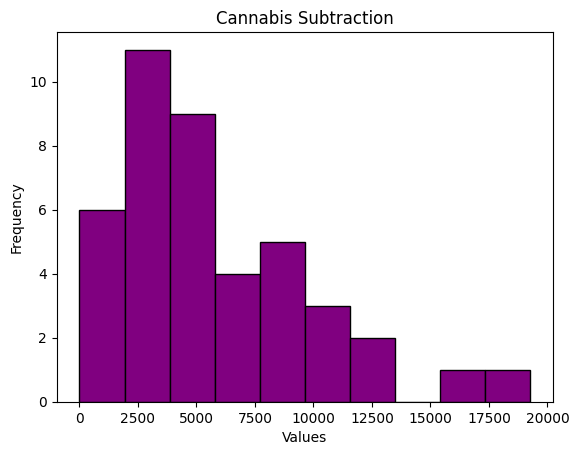

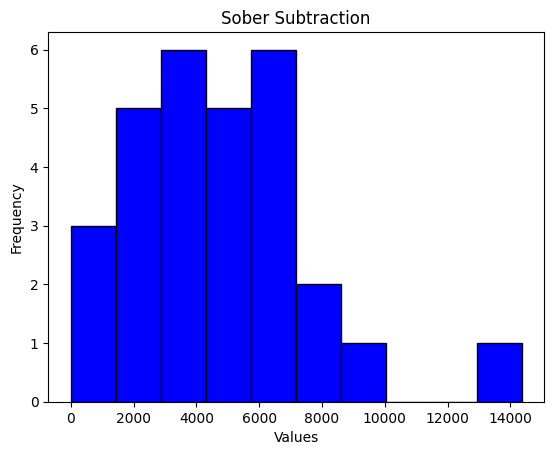

In [288]:
hot_sub = hot[hot['operand'] == '-']
hot_sub = hot_sub[hot_sub['time'] <= 30000]
control_sub = control[control['operand'] == '-']

plot_hist(hot_sub, 'Cannabis Subtraction', True)
plot_hist(control_sub, 'Sober Subtraction', False)

Now let's pull out those statistics!

In [289]:
print("Cannabis Subtraction Statistics")
print_stats(hot_sub)

print("Sober Addition Statistics")
print_stats(control_sub)

Cannabis Subtraction Statistics
	Standard deviation: 4140.57
	Average: 5830.02
	Median: 4669 

Sober Addition Statistics
	Standard deviation: 2991.02
	Average: 4583.38
	Median: 4358 



Now let's take a loot at addition. I expect this to be closer since I find addition much easier.

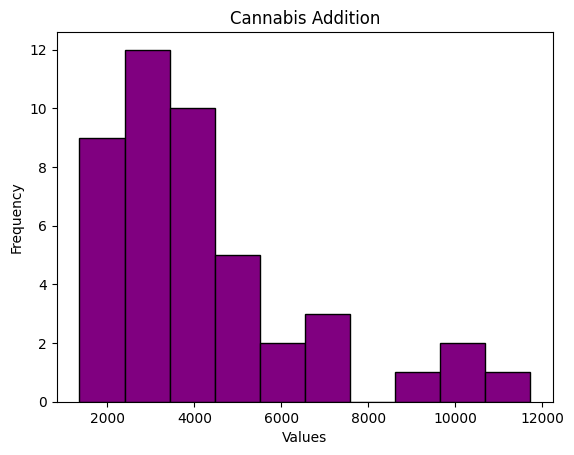

Cannabis Addition
	Standard deviation: 2388.12
	Average: 4144.78
	Median: 3522 



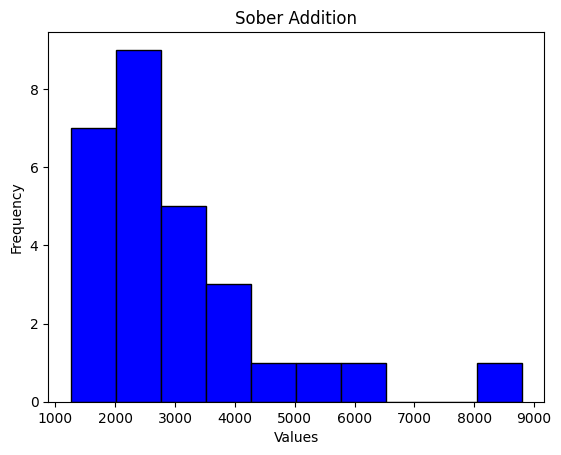

Sober Addition
	Standard deviation: 1644.11
	Average: 3018.68
	Median: 2438 



In [290]:
hot_add = hot[hot['operand'] == '+']
control_add = control[control['operand'] == '+']

plot_hist(hot_add, "Cannabis Addition", True)
print("Cannabis Addition")
print_stats(hot_add)
plot_hist(control_add, "Sober Addition", False)
print("Sober Addition")
print_stats(control_add)

As we can see here, the sober values have a lower average time, a tighter spread, and follow the bell curve more closely to what we'd expect. Whereas the cannabis values don't follow the bell curve as well and have a wider spread. Further, it can be seen across a lot of these graphs that the cannabis is more likely to have extreme values.<br> In other words, it's more likely for a question to take forever when using cannabis, compared to when sober. I think this is likely due to having more difficultly with complicated tasks. For instance, if I punched in a wrong answer, troubleshooting it by realizing which button I did or didn't click is very different then answering the questions. Simple math and binary addition/subtraction is something I have done before and is routine. Troubleshooting the inputs on my Arduino is not, so when I needed to do that while under the influence, it took a lot longer.

Lastly, for the histograms, let's compare the trials where the answer is negative. In order to answer these questions, I needed to use 2s complement, which makes it a lot more challenging. I would expect the difference between the 2 groups to be most magnified here:

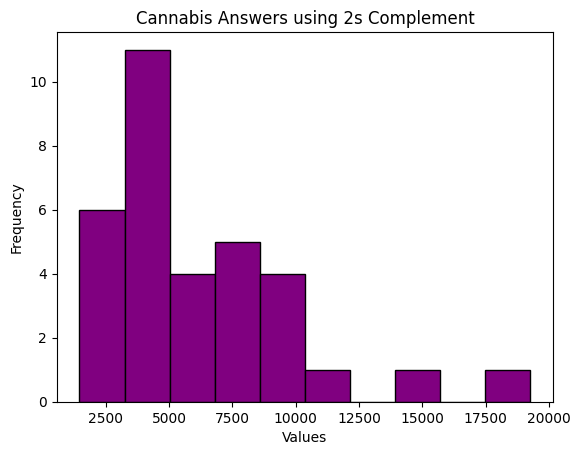

	Standard deviation: 3941.76
	Average: 6181.79
	Median: 4868 



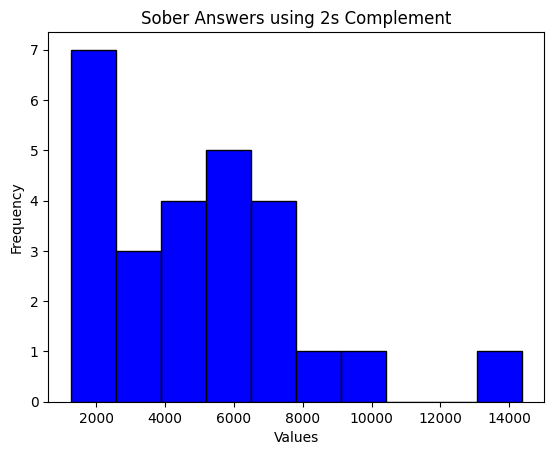

	Standard deviation: 2993.78
	Average: 5025.27
	Median: 4496 



In [291]:
hot_negs = hot[hot['ans'] < 0]
hot_negs = hot_negs[hot_negs['time'] <= 30000] # remove one outlier
control_negs = control[control['ans'] < 0]

plot_hist(hot_negs, "Cannabis Answers using 2s Complement", True)
print_stats(hot_negs)

plot_hist(control_negs, "Sober Answers using 2s Complement", False)
print_stats(control_negs)

Here we can once again see a pattern emerge. The sober data on average contain faster response timnes, and have a tighter spread. Meaning that being sober makes you faster and more consistent with answers.

Now, if we print out the answers in both the control and hot version of the task, let's see if we notice any trends

In [292]:
print(hot['ans'].head(10))
print(control['ans'].head(10))

1      0
2      4
3     10
4     10
5      0
6      0
7     -5
8     -5
9     -3
10    -1
Name: ans, dtype: int32
1      0
2      4
3     10
4     10
5      0
6      0
7     -5
8     -5
9     -3
10    -1
Name: ans, dtype: int32


Well, how interesting. They are the same! The Arduino random function isn't completely random, which is understandable given the low level nature of Arduino and computational complexity of true randomness. I did not notice this until I began looking at the data, so I'm curious to see how it would effect the results. I would expect it to decrease the response times in favour of cannabis (as cannabis was tested after sober, obviously) but seeing as how cannabis is performing worse than the sober version, I will disregard this.

<br>
This does, however, let us compare the two groups on a per question basis! I will do a scatter plot of all the times to see the difference.

First, I will need to subset the data again. The hot data had a trial of 10 minutes, whereas the sober data was only 5. If we only look at the repeated entries, this will give us a more accurate description of the data.

In [293]:
# get length
num_trials = len(control)
hot_short = hot.head(num_trials)

Upon visual inspection, it appears that the cannabis usually performs worse than the sober counterpart. Let's try and pull out some stats to see if this is always the case:

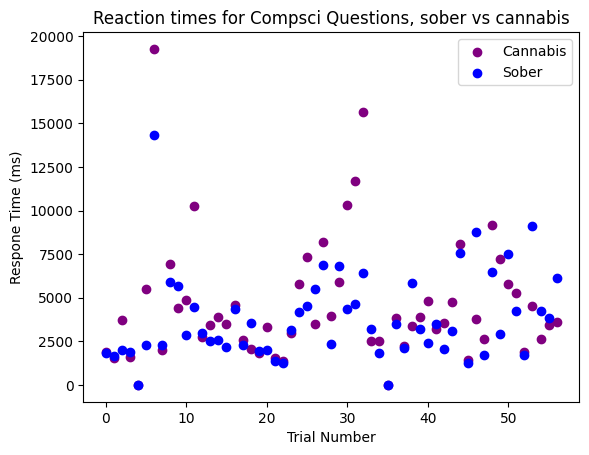

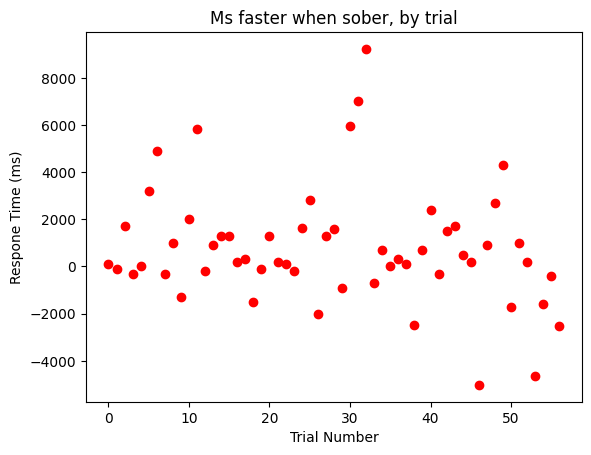

	Standard deviation: 2485.28
	Average: 785.39
	Median: 300 



In [294]:
d=scatter_differences_print_statistics(hot_short, control)

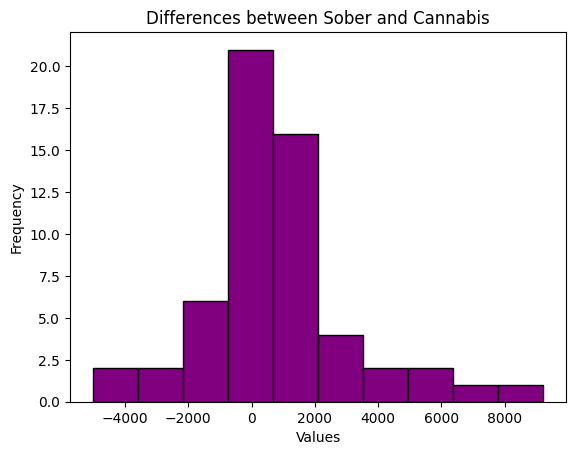

In [295]:
plot_hist(None,'Differences between Sober and Cannabis',True,d)

Here we can see that the differences between the two by trial are in fact normally distributed. Let's scatter this on one line to see how they behave:

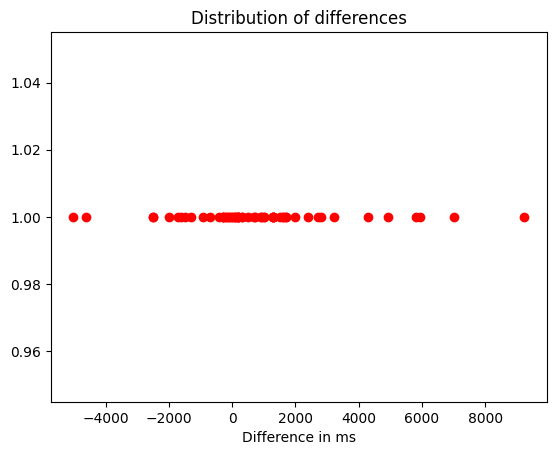

In [296]:
# indices = [n for n in range(len(d))]
x_vals = [1 for n in range(len(d))]
plt.clf()
plt.scatter(d, x_vals, c='Red')
plt.title('Distribution of differences')
plt.xlabel('Difference in ms')
plt.show()

Now let's repeat the same comparisons with the 2s complements data:

In [297]:
h_2s = hot_short[hot_short['ans'] < 0]
c_2s = control[control['ans'] < 0]

if len(h_2s) == len(c_2s):
  print("phew") # they should be the same length, if not something difficult to debug happened

phew


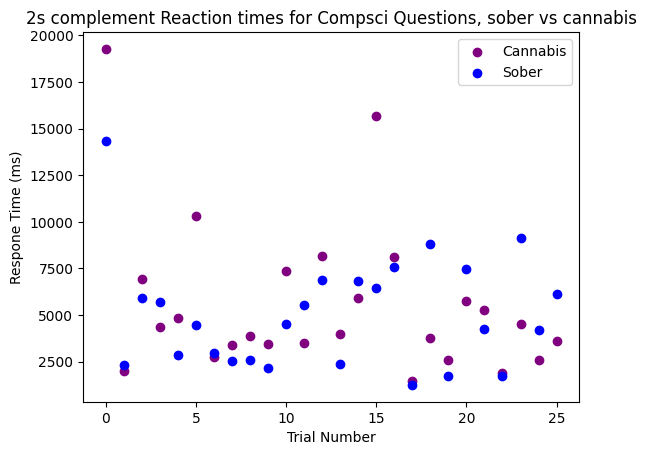

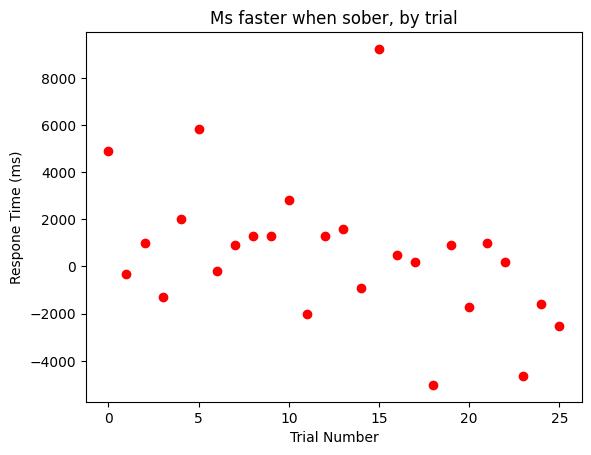

	Standard deviation: 2989.56
	Average: 568.69
	Median: 700 



In [298]:
d = scatter_differences_print_statistics(h_2s, c_2s, name='2s complement ')

Lastly, I want to see if there are any time based differences between the 2 data sets.

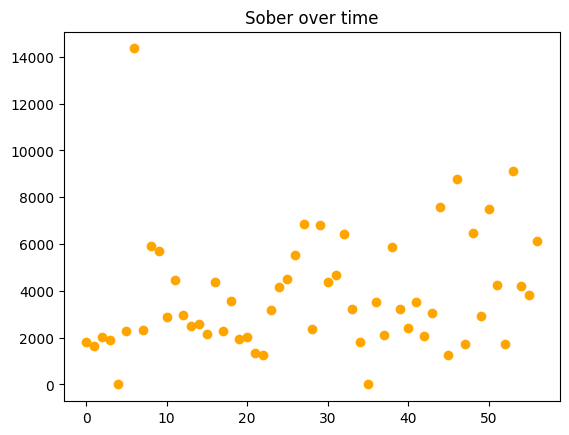

In [299]:
c_d = control['time'].tolist()
indices = [n for n in range(len(c_d))]
plt.clf()
plt.scatter(indices, c_d, c='orange')
plt.title('Sober over time')
plt.show()

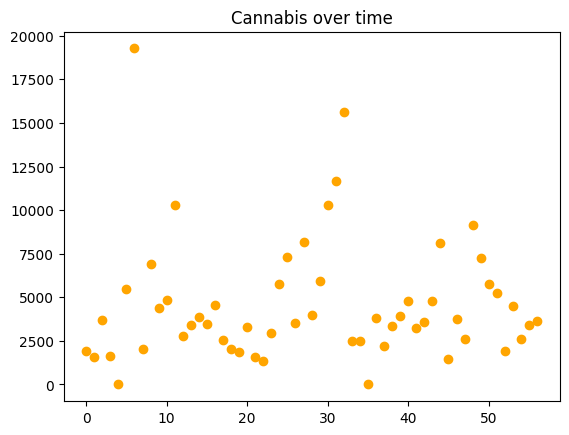

In [300]:
h_d = hot_short['time'].tolist()
indices = [n for n in range(len(h_d))]
plt.clf()
plt.scatter(indices, h_d, c='orange')
plt.title('Cannabis over time')
plt.show()

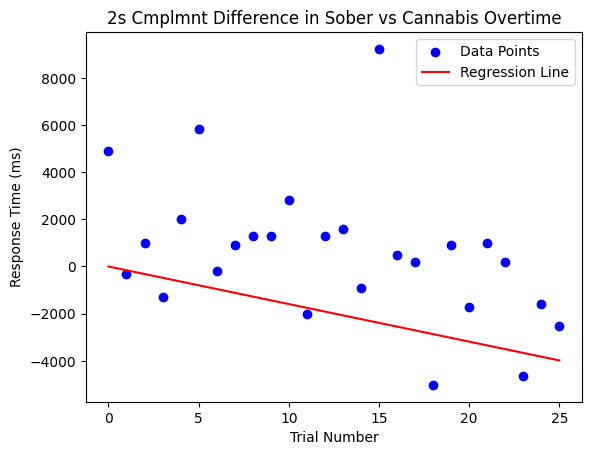

y = -159.37x + 2560.85
Correlation Coefficient : -0.41.  


In [302]:
import numpy as np
indices = [n for n in range(len(d))]
m, b = np.polyfit(indices, d, 1)
eqn = f'y = {m:.2f}x + {b:.2f}' # y = mx + b


coef=np.corrcoef(indices, d)[0, 1]
c = f'Correlation Coefficient : {coef:.2f}.  '
plt.clf()
plt.scatter(indices, d, color='blue', label='Data Points')
plt.plot(indices, [m * i for i in indices], color='red', label='Regression Line')
plt.legend()
plt.ylabel('Response Time (ms)')
plt.xlabel('Trial Number')
plt.title("2s Cmplmnt Difference in Sober vs Cannabis Overtime")
plt.show()

print(eqn)
print(c)

Contrary to what I anticipated, the discrepency begins to tilt in favour of cannabis as time goes on when doing twos complement subtraction problems. This is interesting as I thought that as time went on, and I became more inhebriated, I would perform worse and that this would be magnified on the most difficult problem. <br> Perhaps as I went on, I became better at doing the 2s complement problems. Moreover, it could be that the hit from the dab pen hit me harder at first (as anyone who's taken a hard hit, like I did, can attest) and I began to recover over time. This, however, would not explain the gradual dip in  **favour** of cannabis towards the end. Had I gone on the sober trial for longer, this could have been explored further.


